# Optimizations
1.GradienDecent

2.NewtonMethod

3.DampedNewtonMethod

4.ReviseNewtonMethod

5.DFP

6.BFGS

7.L_BFGS


In [1]:
from IPython.display import display, Math, Latex
import pycuda.autoinit
import skcuda.linalg as cudalinalg
import skcuda.misc as cudamisc
from sympy import *
import numpy as np

import matplotlib
# matplotlib.use('TkAgg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib inline

disFunc = lambda s : display(Math(s))
#display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))
#display(Math('$$c = \sqrt{a^2 + b^2}$$'))

F:\MyDevelop\python\Anaconda3\lib\site-packages\skcuda\cublas.py:273: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


Define test function


<IPython.core.display.Math object>

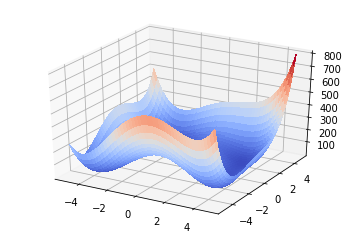

In [2]:
x = Symbol('x')
y = Symbol('y')

print('Define test function')
f    = (x**2 + y -11)**2+(x + y**2 -7)**2
disFunc('f = f(x_1,x_2) = '+latex(f))
    
'Change the symbolic function into numpy function'
f_np = lambdify((x,y), f, "numpy")

'Plot the Test function'
# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = f_np(X ,Y )
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

In [4]:
"find out test function's differential fuction"

diff_x_1 = diff(f,x)
disFunc("\\frac {\\partial f} {\\partial  x_1} = "+latex(diff_x_1))

diff_x_2 = diff(f,y)
disFunc("\\frac {\\partial f} {\\partial x_2} = "+latex(diff_x_2))

print('Gradien vec')
grad = Matrix([diff_x_1,diff_x_2])
disFunc("G(X) = [\\frac {\\partial f} {\\partial x_1} , \\frac {\\partial f} {\\partial x_2} ] = "+latex(grad))

print('Hessian vec')
hess = hessian(f,(x,y))
# disFunc("X = [ x_1,x_2 ]")
disFunc("H(X) = "+latex(hess))


'Change the symbolic Gradien and Hessian into numpy function'
grad_np = lambdify((x,y), grad, "numpy")
hess_np = lambdify((x,y), hess, "numpy")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Gradien vec


<IPython.core.display.Math object>

Hessian vec


<IPython.core.display.Math object>

## 1.GradienDecent

In [5]:
def GradienDecent(X_0,fun,Gradient,rho=0.5,sigma = 0.4,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot  
    norm = np.linalg.norm
    vals = X_0.T
#     print(Gradient(*vals))
    for i in range(Maxepoch):
        gk = Gradient(*vals)
        # -gk means function minimizing
        dk = -gk
        if norm(dk) < epsilon:  break         
        
        # This part is called linear search, intend to find out gradient step-size
        # In other words,'learning rate' of gradient
        m,mk = (0,0)
        f0 = fun(*vals)
        for m in range(20):
            v1 = (vals+rho**m*dk.T[0])
            f1 = fun(*v1)
            if f1 < f0 + sigma*rho**m*gk.T.dot(dk):
                mk=m
                break        
        vals += rho**mk* dk.T[0]
        if mk==0:
            yield vals,f0
        else:
            yield vals,f1

In [7]:
np_toFloat = lambda x : np.asarray(x).astype(np.float32)
processList=np_toFloat([[-10,10, f_np(-10,10)]]) # [[x,y,z]]
cnt=0
for i in GradienDecent( processList[0][:2], f_np,grad_np):
    processList=np.append(processList,[np.append(i[0],i[-1])],axis=0)
    cnt+=1
print(cnt)

17


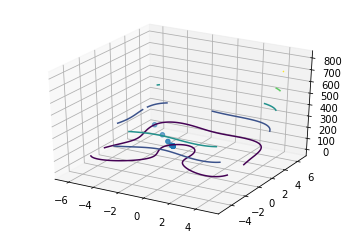

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(*processList.T[:2].tolist())
# ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0,antialiased=False,alpha=0.5)
ax.contour(X, Y, Z)
plt.show() 

In [193]:
processList[-1]

array([ -2.4595089 ,   6.05628252,  11.97324041])

In [133]:
np.append(i[0],i[-1])

array([-1600.        ,   402.        ,    24.46511896])

In [147]:
[[i[0][0],i[0][1],i[-1]]]

[[-1600.0, 402.0, 24.46511896423749]]